# Dialog: Test task, Vladimir Andryushechkin

Требуется разработать классификатор для встраивания в наш push-сервис. 

Нужно классифицировать картинку по трем категориям: 

- фото 
- скриншот
- просто картинка

Выполненное задание мы ожидаем в виде репозитория на github с readme  инструкциями для проверки. 
Для ускорения проверки вашего задания результат работ желательно завернуть в docker контейнер и написать инструкцию по запуску.

Данное задание предполагает самостоятельного выполнения.  
Если Вы считаете, что в задаче не хватает критериев или условий (например, «скриншот с телефона или с десктопа»), то Вы вправе задать эти условия самостоятельно, ровно как и выбрать вариацию изображений.

Желаем успехов в выполнении данного задания! Мы верим – Вы справитесь 


# Code

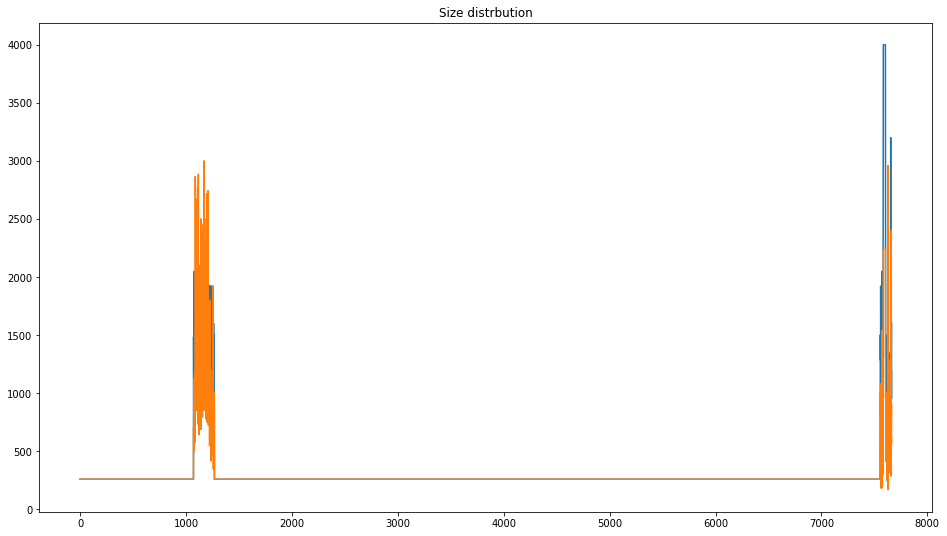

In [3]:
W,H = [],[]

for entry in trainSet:    
    img = Image.open( os.path.join(path_trainData, entry['label'], entry['name']) )
    w,h = img.size
    W.append(w)
    H.append(h)


plt.figure(num=None, figsize=(16, 9))

plt.title('Size distrbution')
plt.plot(W)
plt.plot(H)
plt.show()

## Dataset Loading

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms

from sklearn.externals import joblib

EPOCHS = 35
BATCH_SIZE = 32
LEARNING_RATE = 0.003
IMAGE_SIZE = 32
TRAIN_DATA_PATH = os.path.join('data','train')
TEST_DATA_PATH = os.path.join('data','test')

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
#     transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

TRANSFORM_IMG = transforms.Compose([
                transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

print("Train: %d samples and %d batches" % (len(train_data) , len(train_data_loader)))
print("Test: %d samples and %d batches" % (len(test_data), len(test_data_loader)) )
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure

Train: 7664 samples and 240 batches
Test: 895 samples and 28 batches
Detected Classes are:  {'image': 0, 'photo': 1, 'screenshot': 2}


In [5]:
labels_mapping = train_data.class_to_idx
labels_mapping.update(dict((v,k) for k,v in labels_mapping.items()))
labels_mapping

{'image': 0,
 'photo': 1,
 'screenshot': 2,
 0: 'image',
 1: 'photo',
 2: 'screenshot'}

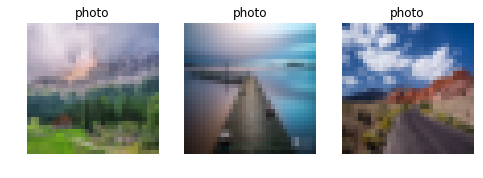

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional 

fig = plt.figure(figsize=(8,8))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    _id = np.random.randint(len(train_data))    
    
    img = train_data[_id][0] / 2 + 0.5
    npimg =  np.transpose(img.numpy(), (1, 2, 0))
    
    fig.add_subplot(rows, columns, i)    
    plt.title(labels_mapping[train_data[_id][1]])
    plt.axis('off')
    plt.imshow(npimg)
plt.show()

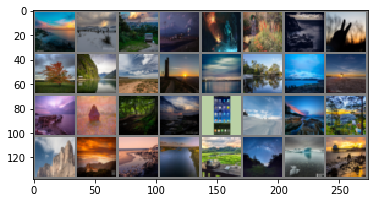

photo photo photo image image image photo photo


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg =  np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels_mapping[labels[j].item()] for j in range(8)))

## Model training

In [116]:
# import inspect
# print(inspect.getsource(print))

In [8]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class Network(nn.Module):
    def __init__(self,num_classes=10):
        super(Network,self).__init__()
        
        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output
    
    
from torch.optim import Adam

model = Network(num_classes=3)

cuda_avail = torch.cuda.is_available()
if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

# Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [10]:
def save_models(epoch, folder = 'models', modelName='ips_model_'):
    path = os.path.join(folder,modelName+str(epoch))
    torch.save(model.state_dict(), path+'.dict')
    
    # save the model to disk
#     joblib.dump(model, path+'.dump')
#     print("Chekcpoint saved as %s and %s" % (path+'.dict', path+'.dump'))
    print("Chekcpoint saved as %s" % path+'.dict')
    
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_data_loader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)

    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc.item() / len(test_data)

    return test_acc

def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_data_loader):
            # Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the test set
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data[0] * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)

        # Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        # Compute the average acc and loss over all 50000 training images
        train_acc = train_acc.item() / len(train_data)
        train_loss = train_loss.item() / len(train_data)

        # Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))
                        
train(num_epochs=EPOCHS)

## Classification

In [18]:
def get_most_frequent(array):
    most_common, num_most_common = Counter(array).most_common(1)[0] 
    return most_common


def predict_image(image_path, model):
    image = Image.open(image_path)
    image = image.resize((self.image_size,self.image_size)).convert('RGB')
    transformation = transforms.Compose([
                transforms.Resize((self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image_tensor = transformation(image).float().unsqueeze_(0)   
    input = Variable(image_tensor)
    output = model(input)
    probabilities = [np.argmax(item) for item in output.data.numpy()]
    index = get_most_frequent( probabilities )
    return index
    
# image_file = 'data/example/orig_NNvqMow.gif'
# image_file = 'data/example/7blsbotrkxoz.jpg'
# image_file = 'data/example/screenshot-android.png'

image_path = os.path.join(os.getcwd(), image_file)

index = predict_image(image_path, model)
print("Predicted Class: %d, %s" % (index, labels_mapping_full[index]))

Prediction in progress
Predicted Class  2
